In [1]:
# Standard Imports
import nltk
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
import re
import ftfy
from IPython.display                 import display_html
from IPython.core.display            import display, HTML

# Proprocessing, Modeling, & Evaluation
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef,roc_curve,auc
from sklearn.pipeline                import Pipeline
from sklearn.svm                     import SVC
#from sklearn.tree                    import DecisionTreeClassifier
from sklearn                         import model_selection
#from xgboost                         import XGBClassifier
   

# Custom Modules
import graphs
import metrics


# Notebook settings & styles
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

In [2]:
Annotated_Sample = pd.read_csv('./Reddit Data/All/Reddit Eczema_All_20201201_Sample_Annotated.csv', encoding = "iso-8859-1" )


In [3]:
# Downloading the default stopwords

nltk.download("stopwords");

# Adding our stopwords to the English set

#new_stopwords = ["like", "just", "make", "cook","use", "chicken", "recipe", "sauce"]

stopwords     = stopwords.words('english')

#stopwords.extend(new_stopwords)

# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ying.Ying_Zenbook\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ying.Ying_Zenbook\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def cleaning_data(dataframe):
   
    if 'Annotation' in dataframe :
        dataframe["label"] = dataframe["Annotation"].apply(lambda x: 1 if x == "R" else 0)
    
    #Annotated_Sample.drop(columns=['Annotation'],inplace=True)
    dataframe.rename(columns={'Author':'author'},inplace=True)
    
    #lower case
    
    dataframe["body"] = dataframe["body"].astype(str)
    
    dataframe["body"] = dataframe["body"].str.lower()
    
    dataframe ["body"] = dataframe ["body"].map(ftfy.fix_encoding)
    
    #remove URL
    dataframe["body"] = dataframe["body"].str.replace("http\S+", "")
    
    #remove none letters
    
    dataframe["body"] =  dataframe["body"].apply(lambda x: re.sub(r'[^a-z]',' ',str(x)))
    
    # Setting up the lemmatizer

    lemmatized_posts = []

    for post in dataframe["body"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))

    # Appending the lemmatized posts to the dataframe

    dataframe["lemmatized_text"] = lemmatized_posts

    # Checking the head of the dataframe
    #dataframe.head()

    return dataframe


In [5]:
Annotated_Sample = cleaning_data(Annotated_Sample)
Annotated_Sample.head()

,author,body,Annotation,label,lemmatized_text
0,touchyfeelies,thanks,I,0,thanks
1,Replacementheart,oh wow i m local and i just moved here haha,I,0,oh wow i m local and i just moved here haha
2,Grumpy_Frenchman,but if you never stop,I,0,but if you never stop
3,UnhingedMom,google calendar same place i track the rest o...,I,0,google calendar same place i track the rest of...
4,princesskailynkitten,wow very thorough thank you so much for inc...,I,0,wow very thorough thank you so much for includ...


### CountVectorizer

Convert a collection of text documents to a matrix of token counts

<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>

In [6]:
vec_lem = CountVectorizer(ngram_range =(1,2),stop_words = None,min_df=10,max_features=500)

vec_sample_lem     = vec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

sample_vectorized_lem     = pd.DataFrame(vec_sample_lem.toarray(), columns = vec_lem.get_feature_names())

sample_vectorized_lem.sum().sort_values(ascending=False)





the          1780
it           1743
and          1688
to           1585
my           1144
             ... 
the first      23
bed            23
now and        23
not sure       23
good luck      23
Length: 500, dtype: int64

### TfidfVectorizer

TF-IDF (term frequency-inverse document frequency) was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document, but is offset by the number of documents that contain the word. 


<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html>

In [7]:
tvec_lem = TfidfVectorizer(ngram_range =(1,2),stop_words = None,min_df=10,max_features=500)

tvec_sample_lem     = tvec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

tsample_vectorized_lem     = pd.DataFrame(tvec_sample_lem.toarray(),columns = tvec_lem.get_feature_names())

tsample_vectorized_lem.T[0].sort_values(ascending=False)

thanks       1.0
your skin    0.0
having       0.0
got          0.0
great        0.0
            ... 
seem         0.0
seems        0.0
severe       0.0
shampoo      0.0
able         0.0
Name: 0, Length: 500, dtype: float64

# Modelling

__Create Test and Training data split__

In [8]:

X = Annotated_Sample["lemmatized_text"]
y = Annotated_Sample["label"]

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

## Support Vector Classifier

A support vector machine (in this case a classifier) is at its core a linear model. However, instead of running like a logistic regression, it seeks to linearly separate the data. To do that, it uses a kernel to raise the data into n-dimensional space. It then uses a line, plane (3-dimensional line), or hyperplane (greater than 3-dimensions) to delineate the data

__Count Vectorizer__


In [9]:
# Setting up the pipeline

cvec_svc_pipe = Pipeline([("cvec", CountVectorizer()), 
                         ("svc", SVC())])

# Setting CVEC and pipe hyperparameters
"""
cvec_pipe_params = {"cvec__max_features": [250], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stopwords],
                    "cvec__min_df"      : [2],
                    "svc__C"            : [1,1.5,2],
                    "svc__kernel"       : ["linear","rbf"],
                    "svc__gamma"        : [0.15,0.25, 0.35]}
"""

                    

cvec_pipe_params = {"cvec__max_features": [250], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stopwords],
                    "cvec__min_df"      : [2],
                    "svc__C"            : [2,1.2,2.3],
                    "svc__kernel"       : ["linear"],
                    "svc__gamma"        : ['scale'],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

cvec_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_pipe_params, 
                           cv         = 10,
                           refit=True)


# Fitting the model to the training data

cvec_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(cvec_svc_gs.best_params_) 


{'cvec__max_features': 250, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'mo

In [10]:

# Generating training predictions

cvec_svc_train_preds = cvec_svc_gs.predict(X_train)

cvec_svc_train_proba = cvec_svc_gs.predict(X_train)

# Training metrics

metrics.binary_classification_summary(y_train, cvec_svc_train_preds,cvec_svc_train_proba)

,Score
Accuracy,0.967509
Sensitivity,0.966325
Specificity,0.972973
AUROC,0.969649
Matthews Corr. Coef.,0.896814


### Validating on test dataset

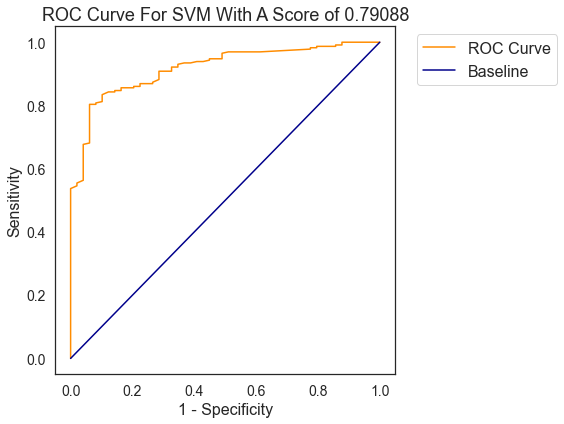

In [11]:
# Generating test predictions

cvec_svc_preds       = cvec_svc_gs.predict(X_test)

cvec_svc_proba=cvec_svc_gs.predict_proba(X_test)[:,1]

# plot test roc_curve#1
graphs.roc_curve(model_prob  = cvec_svc_gs,
                 X_test      = X_test,
                 y_test      = y_test,
                 y_predicted = cvec_svc_preds,
                 title       = "ROC Curve For SVM",
                 dim         = (8,6))



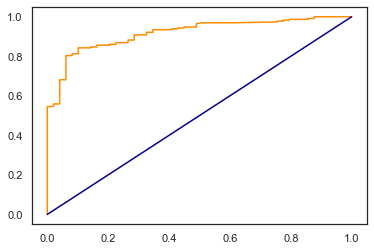

In [12]:
# plot test roc_curve#2

cfprs,ctprs,cthresholds = roc_curve(y_test, cvec_svc_proba)
plt.plot(cfprs,ctprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')

In [13]:
# Test metrics

AUROC = auc(cfprs,ctprs)

roc_auc=roc_auc_score(y_test, cvec_svc_proba)

print('AUROC={} ; roc_auc= {} '.format(AUROC,roc_auc))


metrics.binary_classification_summary(y_test, cvec_svc_preds,cvec_svc_proba)

AUROC=0.9178326352375011 ; roc_auc= 0.9178326352375011 


,Score
Accuracy,0.866906
Sensitivity,0.908297
Specificity,0.673469
AUROC,0.917833
Matthews Corr. Coef.,0.560329


In [14]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_svc_preds,
                                   columns = ["Predicted Irrelated", "Predicted Related"],
                                   index   = ["Actual Irrelated", "Actual Related"])

,Predicted Irrelated,Predicted Related
Actual Irrelated,33,16
Actual Related,21,208


**TFIDF Vectorizer**


In [15]:
# Setting up the pipeline

tvec_svc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("svc", SVC())])

# Setting TFIDF and pipe hyperparameters
"""
tvec_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stopwords],
                    "tvec__min_df"      : [2],
                    "svc__C"            : [2,2.5,3.5],
                    "svc__kernel"       : ["linear","rbf"],
                    "svc__gamma"        : [0.5,0.75,1]}



"""

tvec_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stopwords],
                    "tvec__min_df"      : [2],
                    "svc__C"            : [1.8,2,2.2],
                    "svc__kernel"       : ["linear"],
                    "svc__gamma"        : [0.0001,0.00025,0.005],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_pipe_params, 
                           cv         = 10)


# Fitting the model to the training data

tvec_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_svc_gs.best_params_) 


{'svc__C': 2.2, 'svc__gamma': 0.0001, 'svc__kernel': 'linear', 'svc__probability': True, 'tvec__max_features': 250, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 

In [16]:
# Generating training predictions

tvec_svc_train_preds = tvec_svc_gs.predict(X_train)
tvec_svc_train_proba = tvec_svc_gs.predict_proba(X_train)[:,1]

# Training metrics

metrics.binary_classification_summary(y_train, tvec_svc_train_preds,tvec_svc_train_proba)

,Score
Accuracy,0.944645
Sensitivity,0.970717
Specificity,0.824324
AUROC,0.974808
Matthews Corr. Coef.,0.808123


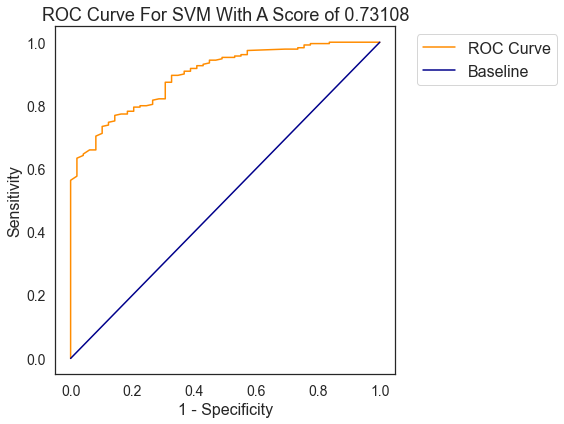

In [17]:
# Generating test predictions

tvec_svc_preds       = tvec_svc_gs.predict(X_test)

tvec_svc_proba       = tvec_svc_gs.predict_proba(X_test)[:,1]
#tvec_svc_proba.shape

# plot test roc_curve#1
graphs.roc_curve(model_prob  = tvec_svc_gs,
                 X_test      = X_test,
                 y_test      = y_test,
                 y_predicted = tvec_svc_preds,
                 title       = "ROC Curve For SVM",
                 dim         = (8,6))



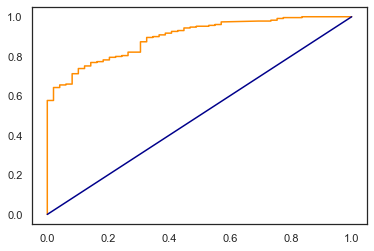

In [18]:
# plot test roc_curve#2
tfprs,ttprs,tthresholds = roc_curve(y_test, tvec_svc_proba)
plt.plot(tfprs,ttprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')
#print(roc_curve(y_test, tvec_svc_proba))

In [19]:
# Test metrics

AUROC = auc(tfprs,ttprs)

roc_auc=roc_auc_score(y_test, tvec_svc_proba)

print('AUROC={} ; roc_auc= {} '.format(AUROC,roc_auc))

# Test metrics
metrics.binary_classification_summary(y_test, tvec_svc_preds,tvec_svc_proba)

AUROC=0.8965332858034043 ; roc_auc= 0.8965332858034043 


,Score
Accuracy,0.874101
Sensitivity,0.951965
Specificity,0.510204
AUROC,0.896533
Matthews Corr. Coef.,0.524515


In [20]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_svc_preds,
                                   columns = ["Predicted Irrelated", "Predicted Related"],
                                   index   = ["Actual Irrelated", "Actual Related"])

,Predicted Irrelated,Predicted Related
Actual Irrelated,25,24
Actual Related,11,218


## Evaluation

In [21]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

In [22]:

vec_accuracy          = [
                          accuracy_score(y_test, cvec_svc_preds),
                          accuracy_score(y_test, tvec_svc_preds)
                        ]

vec_specificity       = [
                          metrics.specificity(y_test, cvec_svc_preds),
                          metrics.specificity(y_test, tvec_svc_preds)
                        ]

vec_sensitivity       = [
                          recall_score(y_test, cvec_svc_preds),
                          recall_score(y_test, tvec_svc_preds)
                        ]

vec_rocauc_score      = [
                          roc_auc_score(y_test, cvec_svc_proba),
                          roc_auc_score(y_test, tvec_svc_proba)
                        ]

vec_matthews_corrcoef = [
                         matthews_corrcoef(y_test, cvec_svc_preds),
                        matthews_corrcoef(y_test, tvec_svc_preds)]

In [23]:
# Converting the lists into dataframes

# A dataframe for the CVEC scores

vec_scores = pd.DataFrame(data    = [vec_accuracy, vec_specificity, 
                                      vec_sensitivity, vec_rocauc_score, 
                                      vec_matthews_corrcoef],
                           columns = [ "CVEC","TVEC"],
                           index   = ["Accuracy", "Specificity", 
                                      "Sensitivity", "AUROC Score", 
                                      "Matthews Corr. Coef."])



In [24]:
# Displaying the two dataframes side by side

display_side_by_side(vec_scores)

# The first table is the CVEC scores
# The second table is the TVEC scores

,CVEC,TVEC
Accuracy,0.866906,0.874101
Specificity,0.673469,0.510204
Sensitivity,0.908297,0.951965
AUROC Score,0.917833,0.896533
Matthews Corr. Coef.,0.560329,0.524515


In [25]:
vec_predictions = pd.DataFrame([np.array(X_test),np.array(y_test), cvec_svc_preds, 
                                 tvec_svc_preds],
                                index = ["body","Actual","CVEC.","TVEC"]).T
vec_predictions.to_csv("./Reddit Data/All/cvec_model_predictions_tuning.csv")

	CVEC	TVEC
Accuracy	0.888489	0.874101
Specificity	0.571429	0.448980
Sensitivity	0.956332	0.965066
AUROC Score	0.763880	0.707023
Matthews Corr. Coef.	0.585403	0.508484

## Save the model to disk


In [ ]:
import pickle

cvec_svc_gs_file = 'cvec_svc_gs.pkl'
pickle.dump(cvec_svc_gs, open(cvec_svc_gs_file, 'wb'))

In [ ]:
tvec_svc_gs_file = 'tvec_svc_gs.pkl'
pickle.dump(tvec_svc_gs, open(tvec_svc_gs_file, 'wb'))

## Use Prediction Model

In [ ]:
# load the models from disk
cvec_svc_gs_load = pickle.load(open(cvec_svc_gs_file, 'rb'))
tvec_svc_gs_load = pickle.load(open(tvec_svc_gs_file, 'rb'))

#load_cvec_svc_gs = pickle.load(cvec_svc_gs)
#load_tvec_svc_gs = pickle.load(tvec_svc_gs)




In [ ]:
def predict(dataframe):

    pred_text= dataframe["lemmatized_text"]
    
  
    # For cvec models
   
    cvec_svc_preds_test = cvec_svc_gs_load.predict(pred_text) 

    # For tvec models
    tvec_svc_preds_test = tvec_svc_gs_load.predict(pred_text) 
    
    # For tvec models
    vec_svc_preds_test = cvec_svc_preds_test+tvec_svc_preds_test
       
    vec_predictions = pd.DataFrame([np.array(pred_text),cvec_svc_preds_test, tvec_svc_preds_test,vec_svc_preds_test],index = ["body","cvec", "tvec","all"]).T
    
    # Saving the dataframes as csvs
    vec_predictions.to_csv("./Reddit Data/All/Reddit Eczema_All_20201201_pred.csv")

In [ ]:
test_data= pd.read_csv('./Reddit Data/All/Reddit Eczema_All_20201201.csv', encoding="iso-8859-1" )

test_data = cleaning_data(test_data)

test_data.head()

In [ ]:
predict(test_data)
